# SETUP

In [21]:
# TA-LIB
!wget https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!sudo make install
%cd /content


--2022-09-07 19:42:55--  https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-09-07 19:42:57--  https://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)... 79.142.76.130
Connecting to altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)|79.142.76.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330299 (1.3M) [application/x-gzip]
Saving to: ‘ta-lib-0.4.0-src.tar.gz’

ta-lib-0.4.0-src.ta   6%[>                   ]  79.76K  --.-KB/s    in 81s     

20

In [22]:
!pip install backtesting matplotlib TA-Lib pandas_ta scikit-optimize hyperopt

^C
Traceback (most recent call last):
  File "/workspace/habr/jeezy/.venv/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configura

In [82]:
import sys
import datetime
import time
import re
import glob

from functools import partial

import pandas as pd

import backtesting
from backtesting import Strategy
from backtesting import Backtest

import talib
import pandas_ta as ta
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from skopt.plots import plot_objective
from skopt.plots import plot_evaluations

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import requests
import json
import numpy as np

IS_IN_COLAB = 'google.colab' in sys.modules
if not IS_IN_COLAB:
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 150)
    pd.set_option('display.max_rows', 250)


# BASE PARAMETERS


In [51]:
#@title TICKET AND DATAFRAME

TICKER = "BTCUSDT" #@param {type:"string"}
TIME_FRAME = "15m" #@param {type:"string"}
FROM_DATE = "2022-08-01" #@param {type:"string"}
MONEY_START = 100000 #@param {type:"integer"}
COMMISSION_PRST = 0.1 #@param {type:"number"}
COMMISSION = COMMISSION_PRST / 100

In [53]:
# OPTIMIZATION PARAMETERS
OPTIM_TYPE ='Annealing' #@param ['Brute Force', 'Bayesian', 'Annealing']
OPTIM_PARAMETER ='Equity Final [$]' #@param ['Equity Final [$]', 'Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Win Rate [%]', 'Profit Factor']
OPTIM_ITERATION = 100 #@param {type:"integer"}

In [54]:
# Setting the parameter space
#@title The range of parameters to be checked: INDICATORS

# Supetrend
#@markdown ST Period (default: 14)
SHOULD_USE_FAST_MA_PERIOD = True #@param {type:"boolean"}
FAST_MA_LEN_FROM = 2 #@param {type:"integer"}
FAST_MA_LEN_TO = 25 #@param {type:"integer"}
#@markdown ST Factor (default: 2)
SHOULD_USE_SLOW_MA = True #@param {type:"boolean"}
SLOW_MA_LEN_FROM = 3  #@param {type:"integer"}
SLOW_MA_LEN_TO = 50 #@param {type:"integer"}



### AFTER CHANGES DEMAND TO RECALCULATE PARAMETER SPACE IN CELL BELLOW



In [63]:
def get_range_arr(val_from, val_to, mult=None):
  if(mult):
    return [val * mult for val in range(val_from, val_to + 1)]
  return [val for val in range(val_from, val_to + 1)]

def get_float_range_arr(val_from, val_to, mult=0.1):
  return [val * mult for val in range(int(val_from/mult), int(val_to/mult) + 1)]

base_param = {
    # 'stake': 2, #
    'commission': COMMISSION,
    'money_start': MONEY_START,
    # 'slip_perc': 0.005, # TODO Slippage https://www.backtrader.com/docu/slippage/slippage/
    'StartDateTime': FROM_DATE,  # Start Time
    'EndDateTime': None  # End Time
}

search_space = dict(constraint=lambda p: p.p_fast < p.p_slow,maximize=OPTIM_PARAMETER, max_tries=OPTIM_ITERATION, random_state=0, return_heatmap=True)
if OPTIM_TYPE == 'Bayesian':
    search_space['method']='skopt'
    search_space['return_optimization']=True
elif OPTIM_TYPE == 'Annealing':
    search_space = {}
if SHOULD_USE_FAST_MA_PERIOD:
    if OPTIM_TYPE == 'Brute Force': search_space['p_fast']=range(FAST_MA_LEN_FROM, FAST_MA_LEN_TO, 1)
    elif OPTIM_TYPE == 'Annealing':
        search_space['p_fast'] = hp.choice('Fast Len', get_range_arr(FAST_MA_LEN_FROM, FAST_MA_LEN_TO, 1))
    else: search_space['p_fast'] = [FAST_MA_LEN_FROM, FAST_MA_LEN_TO]
if SHOULD_USE_SLOW_MA:
    if OPTIM_TYPE == 'Brute Force': search_space['p_slow']=range(SLOW_MA_LEN_FROM, SLOW_MA_LEN_TO, 1)
    elif OPTIM_TYPE == 'Annealing':
        search_space['p_slow'] = hp.choice('Low Len', get_range_arr(SLOW_MA_LEN_FROM, SLOW_MA_LEN_TO, 1))
    else: search_space['p_slow'] = [SLOW_MA_LEN_FROM, SLOW_MA_LEN_TO]

search_space

{'p_fast': <hyperopt.pyll.base.Apply at 0x7f65b5401eb0>,
 'p_slow': <hyperopt.pyll.base.Apply at 0x7f65b5401850>}

# GET DATA


In [64]:
# init data, also can parse files that exported from tradingview

FN_TICKERS_REGEXP = f'({TICKER}\,\s*{TIME_FRAME}\.csv$)|({TICKER}_{TIME_FRAME}.csv$)'
all_dir = glob.glob('./*.csv', recursive=False) + glob.glob('./data/*.csv', recursive=False)
files_for_ticker = [fn for fn in all_dir if re.search(FN_TICKERS_REGEXP, fn, re.I)]
is_data_has_volume = True

max_val = 0

if files_for_ticker:
    datapath = files_for_ticker[0]
    df = pd.read_csv(datapath, header=0, encoding='utf-8', sep=',')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    is_data_has_volume = 'volume' in df.columns
    df_filtered = df[df['time'] > pd.to_datetime(FROM_DATE)]
    df = df_filtered.reset_index().set_index('time')
else:
    from_date_val = datetime.datetime.fromisoformat(FROM_DATE)
    start_time = int(from_date_val.timestamp() * 1000)

    df = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []

    cur_time = datetime.datetime.utcnow().replace(minute=0, second=0, microsecond=0)
    cur_time = int(cur_time.timestamp()) * 1000 - 1

    if 'perp' in TICKER.lower():
        api_url = f'https://fapi.binance.com/fapi/v1/continuousKlines?pair={TICKER[:-len("perp")]}&interval={TIME_FRAME.lower()}&contractType=PERPETUAL&limit=1000'
    else:
        api_url = f'https://fapi.binance.com/fapi/v1/klines?symbol={TICKER}&interval={TIME_FRAME.lower()}&limit=1000'
    while start_time < cur_time:
        print(f'Get 1000 candles for {TICKER}:{TIME_FRAME} from the datetime {datetime.datetime.utcfromtimestamp(int(start_time / 1000))}')
        sym_info = requests.get(f"{api_url}&startTime={start_time}")
        if (sym_info.status_code == 429):
            raise InterruptedError(f'Limits is violated')
        elif (sym_info.status_code != 200):
            raise InterruptedError(f'Error for request. Code {sym_info.status_code}')
        candles = json.loads(sym_info.text)
        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])
        start_time = closetime[-1]
        time.sleep(0.25)

    df['open_time'] = pd.to_datetime(opentime, unit='ms', origin='unix')
    df['time'] = df['open_time'].apply(lambda x: int(x.timestamp()))
    df['open'] = np.array(lopen).astype(float)
    df['high'] = np.array(lhigh).astype(float)
    df['low'] = np.array(llow).astype(float)
    df['close'] = np.array(lclose).astype(float)
    df['volume'] = np.array(lvol).astype(float)
    df.to_csv(f'./{TICKER}, {TIME_FRAME}.csv', header=True, index=False, date_format='%s', encoding='utf-8',
              sep=',')
    df['time'] = df['open_time']
    df.set_index('time', inplace=True)
    # max_val = df['high'].max()
    is_data_has_volume = 'volume' in df.columns
    # data = TVPandasData(dataname=df, name=TICKER.lower())

max_val = df['high'].max()
df.rename(columns={'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume': 'Volume'}, inplace=True)


In [65]:
if IS_IN_COLAB:
    df
else:
    print(df.head(50))
    print(df.tail(50))

                     index     Open     High      Low    Close     Volume   open_time
time                                                                                 
2022-08-01 00:15:00     41  23271.6  23349.2  23260.1  23343.4   4045.267  1659276900
2022-08-01 00:30:00     42  23343.4  23378.0  23315.0  23347.3   2647.989  1659277800
2022-08-01 00:45:00     43  23346.8  23384.9  23334.0  23365.9   2749.487  1659278700
2022-08-01 01:00:00     44  23365.8  23376.0  23319.3  23369.8   1770.725  1659279600
2022-08-01 01:15:00     45  23369.8  23432.6  23350.4  23419.9   3345.164  1659280500
2022-08-01 01:30:00     46  23419.8  23427.0  23374.9  23414.1   2250.874  1659281400
2022-08-01 01:45:00     47  23414.1  23418.0  23376.7  23407.8   1737.745  1659282300
2022-08-01 02:00:00     48  23407.7  23458.3  23398.3  23422.8   2677.065  1659283200
2022-08-01 02:15:00     49  23422.9  23429.5  23400.0  23414.5   1266.599  1659284100
2022-08-01 02:30:00     50  23414.4  23425.0  23371.9 

# Strategy

In [66]:
class SmaCross(Strategy):
    # Define the two MA lags as *class variables* for later optimization
    p_fast = 9
    p_slow = 21

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(talib.SMA, self.data.Close, self.p_fast)
        self.sma2 = self.I(talib.SMA, self.data.Close, self.p_slow)

    def next(self):
        if self.sma1[-2] < self.sma2[-2] and self.sma1[-1] > self.sma2[-1]:
            self.position.close()
            self.buy()
        elif self.sma1[-2] > self.sma2[-2] and self.sma1[-1] < self.sma2[-1]:
            self.position.close()
            self.sell()

# Backtester functions


In [67]:
def get_bt(data, base_param):
    bt = Backtest(data, SmaCross, cash=base_param['money_start'], commission=base_param['commission'])
    return bt


In [75]:
# Function for external optimization
def runStrategy(data, base_param, vp):
    bt = get_bt(data, base_param)
    stats = bt.run(**vp)

    stats_res = {
        'Equity Final [$]': stats['Equity Final [$]'],
        'Return [%]': stats['Return [%]'],
        'Profit Factor': stats['Profit Factor'],
        'Sharpe Ratio': stats['Sharpe Ratio'],
        'Sortino Ratio': stats['Sortino Ratio'],
        'Calmar Ratio': stats['Calmar Ratio'],
        'Max. Drawdown [%]': stats['Max. Drawdown [%]'],
        'Win Rate [%]': stats['Win Rate [%]'],
        '# Trades': stats['# Trades']
        }
    loss = -(stats[OPTIM_PARAMETER])
    del bt
    del stats

    return {
        'loss': loss,
        'status': STATUS_OK,
        'stats': stats_res,
        'params': vp
    }


# RUN STRATEGY


In [76]:
%%time
best = None
bt = get_bt(df, base_param)
if OPTIM_TYPE == 'Brute Force':
    stats, heatmap = bt.optimize(**search_space)
    optimize_result = None
elif OPTIM_TYPE == 'Bayesian':
    best, heatmap, optimize_result = bt.optimize(**search_space)
elif OPTIM_TYPE == 'Annealing':
    print('Attention\n. Resulting values shows in "best loss" with negative sign (need it for selected optimization method  which uses search for minimum values).')
    trials = Trials()
    partialRunStrategy = partial(runStrategy, df, base_param)
    best = fmin(fn=partialRunStrategy, space=search_space, algo=tpe.suggest, max_evals=OPTIM_ITERATION, trials=trials, show_progressbar=True)


Attention
. Resulting values shows in "best loss" with negative sign (need it for selected optimization method  which uses search for minimum values).


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

 10%|█         | 1/10 [00:00<00:02,  3.85trial/s, best loss: -91243.68430000055]

 20%|██        | 2/10 [00:00<00:02,  3.25trial/s, best loss: -91243.68430000055]

 30%|███       | 3/10 [00:00<00:02,  3.25trial/s, best loss: -91243.68430000055]

 40%|████      | 4/10 [00:01<00:01,  3.15trial/s, best loss: -91857.87820000117]

 50%|█████     | 5/10 [00:01<00:01,  3.47trial/s, best loss: -91857.87820000117]

 60%|██████    | 6/10 [00:01<00:01,  3.67trial/s, best loss: -91857.87820000117]

 70%|███████   | 7/10 [00:01<00:00,  3.95trial/s, best loss: -91857.87820000117]

 80%|████████  | 8/10 [00:02<00:00,  4.25trial/s, best loss: -91857.87820000117]

 90%|█████████ | 9/10 [00:02<00:00,  4.16trial/s, best loss: -91857.87820000117]

100%|██████████| 10/10 [00:02<00:00,  3.84trial/s, be

In [77]:
if OPTIM_TYPE == 'Annealing':
    best_param = space_eval(search_space, best)
    stats = bt.run(**best_param)
stats

Start                     2022-08-01 00:15:00
End                       2022-09-15 04:30:00
Duration                     45 days 04:15:00
Exposure Time [%]                    99.12402
Equity Final [$]                   91857.8782
Equity Peak [$]                   106615.3368
Return [%]                          -8.142122
Buy & Hold Return [%]              -14.413496
Return (Ann.) [%]                  -59.686416
Volatility (Ann.) [%]               23.549386
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -20.34044
Avg. Drawdown [%]                   -1.990139
Max. Drawdown Duration       43 days 00:45:00
Avg. Drawdown Duration        3 days 04:30:00
# Trades                                  236
Win Rate [%]                        61.440678
Best Trade [%]                       5.080736
Worst Trade [%]                     -9.872053
Avg. Trade [%]                    

In [78]:
if OPTIM_TYPE == 'Annealing':
    best_param = space_eval(search_space, best)
    df_best_res = pd.Series(best_param, name='The best combination of parameters')
    print('Optimal parameters for strategy:')
    print(df_best_res)
else:
    print('Optimal parameters for strategy:', stats['_strategy'])

Optimal parameters for strategy:
p_fast    23
p_slow     9
Name: The best combination of parameters, dtype: int64


In [99]:
if OPTIM_TYPE == 'Annealing':
    runs_res = [dict(list(res['stats'].items()) + list(res['params'].items())) for res in trials.results]
    heatmap = pd.DataFrame(runs_res)
    if(OPTIM_PARAMETER in heatmap.columns):
        sorted_res = heatmap.sort_values(OPTIM_PARAMETER, ascending=False)
        # sorted_res.to_csv(f'./res_{TICKER}_{TIME_FRAME}', header=True, index=False, encoding='utf-8', sep=',')
    else:
        sorted_res =  heatmap
    if not IS_IN_COLAB:
        print(sorted_res)
    else:
        sorted_res
    columns = [col for col in heatmap.columns if col not in ['Equity Final [$]',  'Return [%]',  'Profit Factor',  'Sharpe Ratio',  'Sortino Ratio',  'Calmar Ratio',  'Max. Drawdown [%]',  'Win Rate [%]',  '# Trades']] + [OPTIM_PARAMETER]
    heatmap = heatmap[columns]
else:
    heatmap.sort_values().iloc[-5:]

   Equity Final [$]  Return [%]  Profit Factor  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max. Drawdown [%]  Win Rate [%]  # Trades  p_fast  p_slow
3        91857.8782   -8.142122       0.924441           0.0            0.0           0.0         -20.340440     61.440678       236      23       9
0        91243.6843   -8.756316       0.890952           0.0            0.0           0.0         -19.119058     29.268293       123      22      46
6        88977.1664  -11.022834       0.880563           0.0            0.0           0.0         -19.275776     32.478632       117      18      48
7        85792.5382  -14.207462       0.815302           0.0            0.0           0.0         -26.032801     30.656934       137      22      41
5        82645.6715  -17.354328       0.770878           0.0            0.0           0.0         -22.556219     21.818182       220       3      49
4        80568.5154  -19.431485       0.823008           0.0            0.0           0.0         -25.5720

In [91]:
#%matplotlib inline
# Draw the best parameters strategy results
if IS_IN_COLAB:
    backtesting.set_bokeh_output(notebook=True)
bt.plot() # TODO if a lot of candlestick - resample Backtest.plot(resample=...)  '30T' for example.




Row(id='4298', ...)

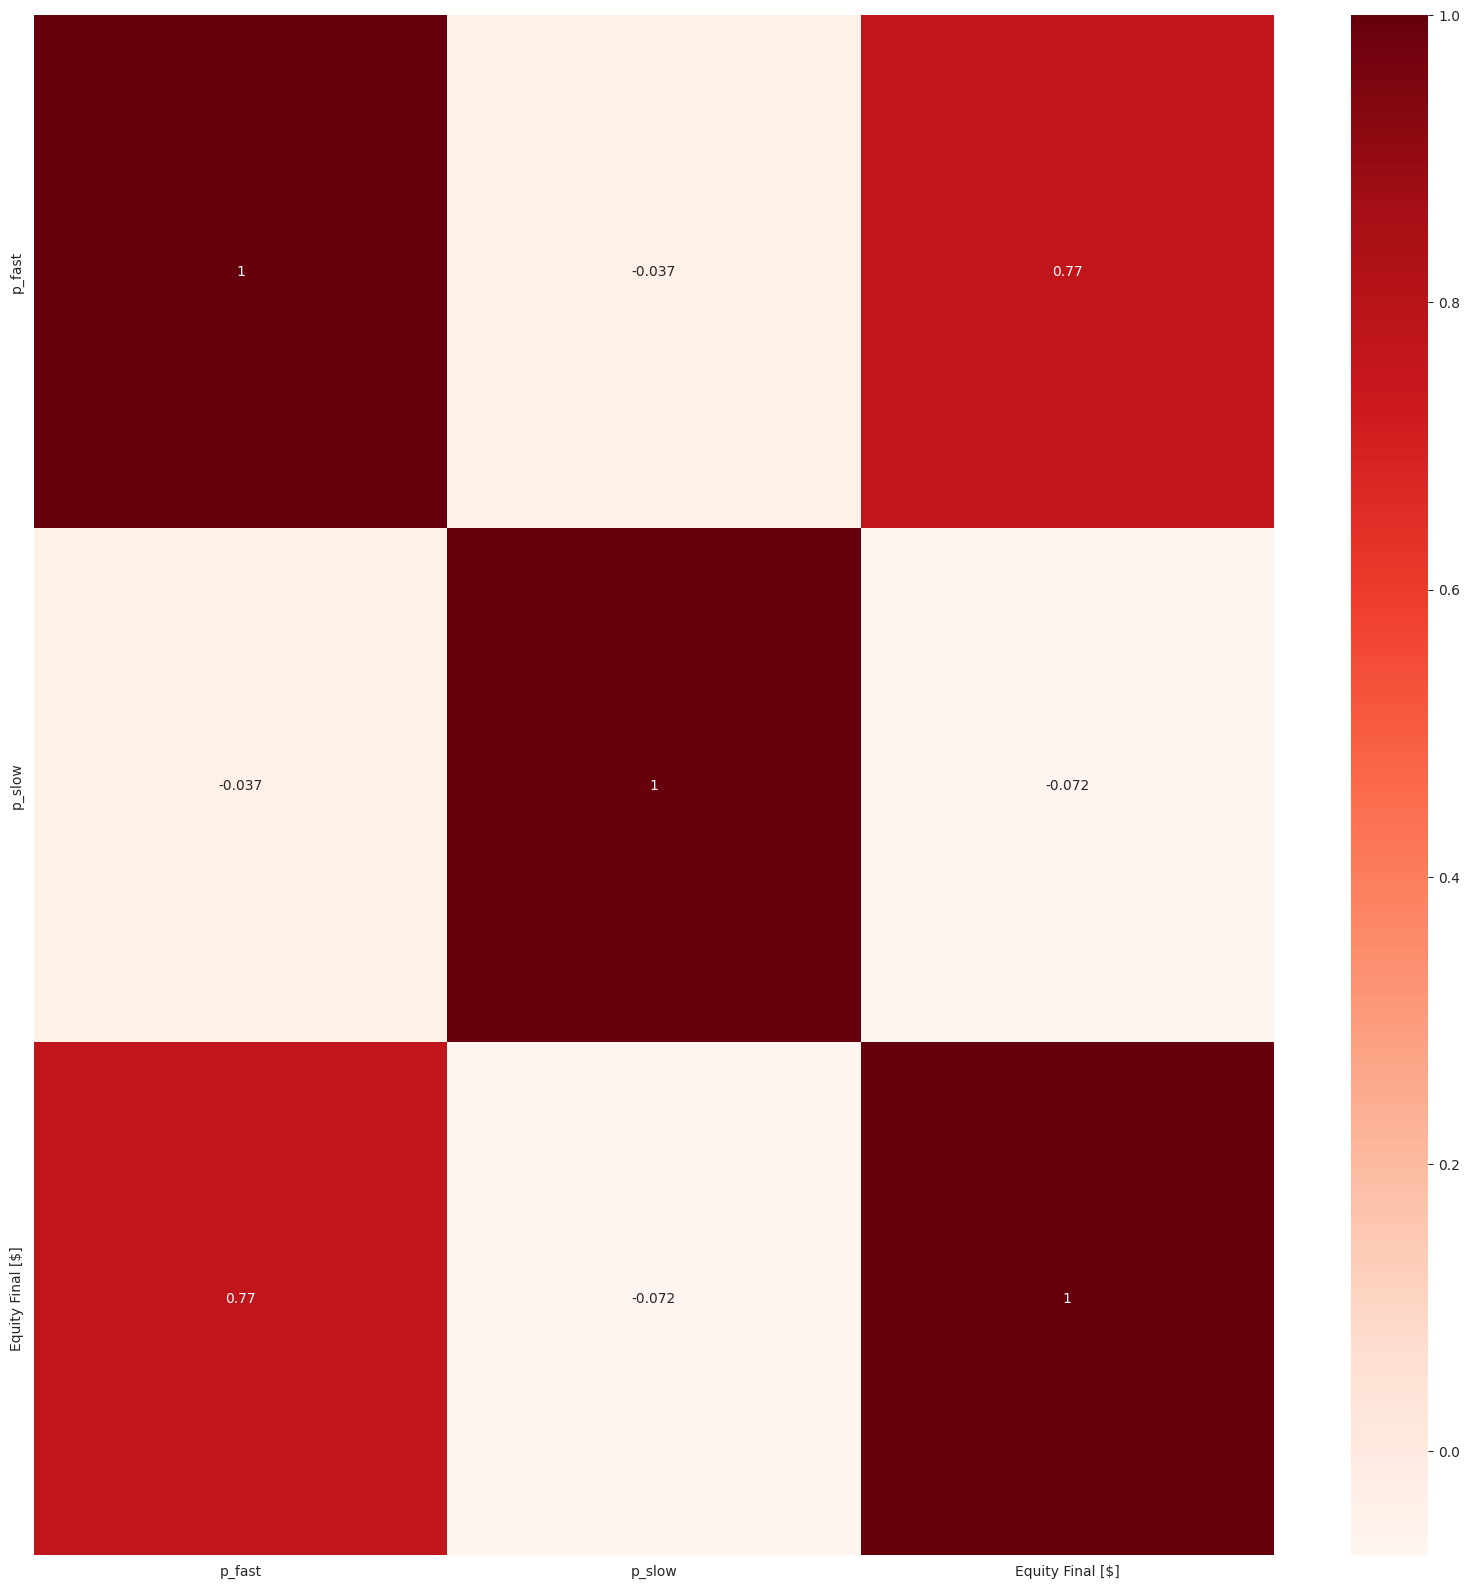

The most correlating parameters with profit:
p_fast    0.769888
p_slow    0.072406
Name: Equity Final [$], dtype: float64


In [120]:
%matplotlib inline
if OPTIM_TYPE == 'Brute Force':
    pass
    #import seaborn as sns
    #sns.heatmap(hm[::-1], cmap='viridis')
elif OPTIM_TYPE == 'Bayesian':
    _ = plot_objective(optimize_result, n_points=10)
elif  OPTIM_TYPE == 'Annealing':
    cor = heatmap.corr()
    matplotlib.pyplot.figure(figsize=(20, 20))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    cor_target = cor[OPTIM_PARAMETER].abs()
# cor_target = cor_target[(cor_target < 0.9999)] # Filter from the same values
    relevant_features = cor_target[[i in best_param.keys() for i in cor_target.index]].sort_values(
    ascending=False)
    print('The most correlating parameters with profit:')

    name_x = relevant_features.index[0]
    name_y = relevant_features.index[1]
    if not IS_IN_COLAB:
        print(relevant_features)
    relevant_features

/tmp/ipykernel_300360/2593352623.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax_plt = fig_plt.gca(projection='3d')
/tmp/ipykernel_300360/2593352623.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plt.show()


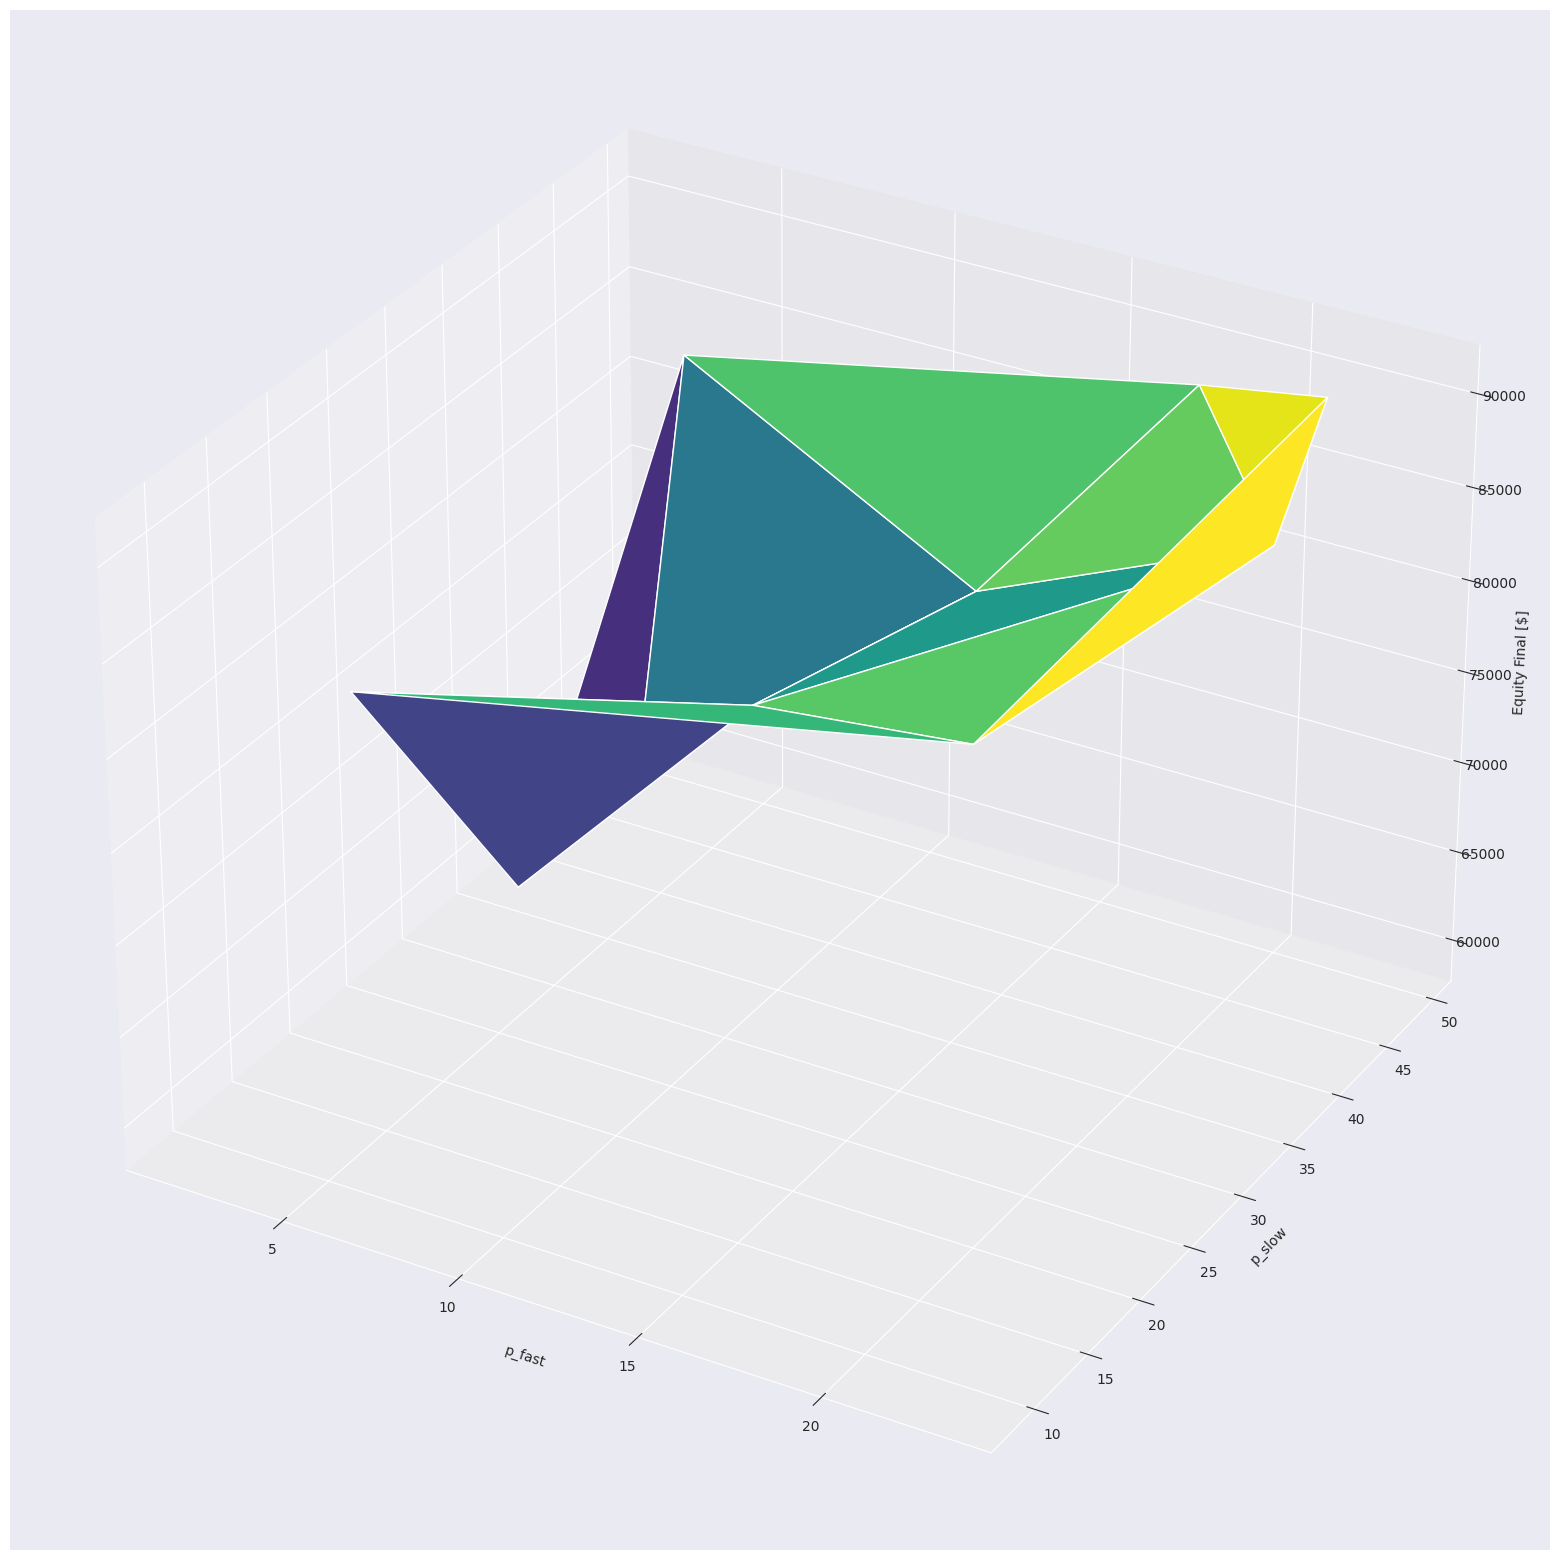

In [114]:
##%matplotlib inline
if OPTIM_TYPE == 'Bayesian':
    _ = plot_evaluations(optimize_result, bins=10)
elif  OPTIM_TYPE == 'Annealing':
    # Profit graph
    fig_plt = plt.figure(figsize=(20, 20))
    ax_plt = fig_plt.gca(projection='3d')
    surf = ax_plt.plot_trisurf(heatmap[name_x], heatmap[name_y], heatmap[OPTIM_PARAMETER], cmap='viridis', label="profit_rate")
    ax_plt.set_xlabel(name_x)
    ax_plt.set_ylabel(name_y)
    ax_plt.set_zlabel(OPTIM_PARAMETER)
    fig_plt.show()